In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 2500        
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

In [5]:
# read training data from CSV file 
data = pd.read_csv('train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [6]:
#根据标签的所在位置，从0开始计数，选取列。，前表示选择的行，，后表示选取的列
#选取除标签外所有的数据
images = data.iloc[:,1:].values
#数值转换
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [7]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
#ceil() 函数返回数字的上入整数。
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


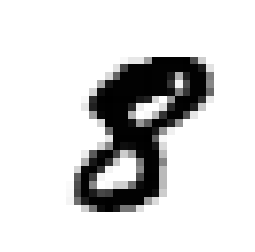

In [8]:
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image     
display(images[IMAGE_TO_DISPLAY])

In [9]:
#array类型对象的方法，ravel函数将多维数组降为一维，仍返回array数组，元素以列排列。42000*1=>1*42000
labels_flat = data.iloc[:,0].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


In [10]:
#获取不同标签值的个数
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [11]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [12]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print(labels.shape)
print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))
print(train_labels.shape)
print(validation_labels.shape)

(42000, 10)
train_images(40000,784)
validation_images(2000,784)
(40000, 10)
(2000, 10)


In [13]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [14]:
def conv2d(x, W):
    #x:输入图像数据
    #W：filter
    #strides：tf在4维图像上进行计算，
    #strides第一个参数表示在batchsize上的滑动，一般指定为1就可以，后边三个参数依次为宽、高、颜色通道上的滑动，
    #一般只修改中间两个值，也就是在宽高上的滑动
    #strides的第四个参数1表示通道上的滑动
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [15]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1
#tf.nn.max_pool(value,kszie,strides,padding,name=None)
#value：需要池化的输入，一般池化层接在卷积层后面，所以输入通常是feature map，依然是[batch, height, width, channels]这样的shape
#ksize：池化窗口的大小，取一个四维向量，一般是[1, height, width, 1]，因为我们不想在batch和channels上做池化，所以这两个维度设为了1
#strides：和卷积类似，窗口在每一个维度上滑动的步长，一般也是[1, stride,stride, 1]
#padding：和卷积类似，可以取'VALID' 或者'SAME'
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [16]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [19]:
# first convolutional layer第一个卷积层计算
#宽5 高5 channel为1 用多少个filter来计算，这里是32
W_conv1 = weight_variable([5, 5, 1, 32])
#执行卷积后得到了32个图，所以需要32个偏置
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)
print("image.shape=", image.shape)

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
print("h_conv1.shape=", h_conv1.shape)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)
print("h_pool1.shape=", h_pool1.shape)

image.shape= (?, 28, 28, 1)
h_conv1.shape= (?, 28, 28, 32)
h_pool1.shape= (?, 14, 14, 32)


In [20]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
print("h_conv2.shape=", h_conv2.shape)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)
print("h_pool2.shape=", h_pool2.shape)

h_conv2.shape= (?, 14, 14, 64)
h_pool2.shape= (?, 7, 7, 64)


In [23]:
# densely connected layer全连接层
W_fc1 = weight_variable([7 * 7 * 64, 1024])
print("W_cf1.shape=", W_fc1.shape)
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
print("h_pool2_flat.shape=", h_pool2_flat.shape)
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)
print("h_fc1.shape=", h_fc1.shape)

W_cf1.shape= (3136, 1024)
h_pool2_flat.shape= (?, 3136)
h_fc1.shape= (?, 1024)


In [22]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [115]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

In [116]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [117]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [118]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [119]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

D:\software_installed\Anaconda\lib\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [120]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0})
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.24 / 0.14 for step 0
training_accuracy / validation_accuracy => 0.06 / 0.06 for step 1
training_accuracy / validation_accuracy => 0.20 / 0.32 for step 2
training_accuracy / validation_accuracy => 0.16 / 0.26 for step 3
training_accuracy / validation_accuracy => 0.24 / 0.26 for step 4
training_accuracy / validation_accuracy => 0.20 / 0.30 for step 5
training_accuracy / validation_accuracy => 0.36 / 0.40 for step 6
training_accuracy / validation_accuracy => 0.46 / 0.32 for step 7
training_accuracy / validation_accuracy => 0.28 / 0.40 for step 8
training_accuracy / validation_accuracy => 0.34 / 0.28 for step 9
training_accuracy / validation_accuracy => 0.34 / 0.46 for step 10
training_accuracy / validation_accuracy => 0.44 / 0.56 for step 20
training_accuracy / validation_accuracy => 0.60 / 0.66 for step 30
training_accuracy / validation_accuracy => 0.68 / 0.68 for step 40
training_accuracy / validation_accuracy => 0.74 / 0.82 for step 50
train

validation_accuracy => 0.9730


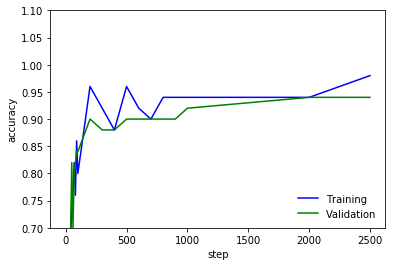

In [121]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [25]:
 474241623

474241623